# ENHANCING CYBERHATE DETECTION ON SOCIAL MEDIA USING TEXT CLASSIFICATION MODELS.

### LIBRARY IMPORTS

In [2]:
import pandas as panda
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
import string
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### DATA LOADING AND DISPLAY

In [2]:
dataset = panda.read_csv(r"FinalBalancedDataset.csv")
dataset

,Toxicity,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
42996,1,I want to beat this bitches ass soooo bad
42997,0,I want to go to the pumpkin patch but the love...
42998,1,I want to paint but faggot won't paint with me...
42999,1,I want to square up with all these hoes.


In [3]:
# collecting only the tweets from the CSV file into a variable name tweet
tweet=dataset.tweet
tweet


0         @user when a father is dysfunctional and is s...
1        @user @user thanks for #lyft credit i can't us...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide: society now    #motivation
                               ...                        
42996            I want to beat this bitches ass soooo bad
42997    I want to go to the pumpkin patch but the love...
42998    I want to paint but faggot won't paint with me...
42999             I want to square up with all these hoes.
43000    I want yo bitch I go get her I smashed er now ...
Name: tweet, Length: 43001, dtype: object

### PRE-PROCESSING 

In [4]:
stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet): 

    # removal of extra spaces
    regex_pat = re.compile('\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ',regex=True)

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '',regex=True)

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '',regex=True)
    
        
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    tweet_d = tweet_lower.str.replace(r'[^\w\s]', '')
    tweet_p = tweet_d.str.replace(r'\d+', '')
    # tokenizing
    tokenized_tweet = tweet_p.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)

def removespace(text):
    rem_spac=r"('^\s+|\s+?$','')"
    return re.sub(rem_spac,"",text)

def removedig(text):
    rem_dig=r"('\d+(\.\d+)?','numbr')"
    return re.sub(rem_dig,"",text)

def removedpunc(text):
    rem_dig=r"('[a-zA-Z]',' ')"
    return re.sub(rem_dig,"",text)

def removed1(text):
    rem_dig=r"('\s+', ' ')"
    return re.sub(rem_dig,"",text)

def removed2(text):
    rem_dig=r"@[\w\-]+"
    return re.sub(rem_dig,"",text)

def remove_urls(text):
    url_pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    return re.sub(url_pattern, "", text)

def remove_mentions(text):
    mention_pattern = r"@[\w\-]+"
    return re.sub(mention_pattern, "", text)

def remove_hashtags(text):
    hashtag_pattern = r"#\w+"
    return re.sub(hashtag_pattern, "", text)

def remove_punctuation(text):
    punctuation_pattern = r"[^\w\s]"
    return re.sub(punctuation_pattern, "", text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word not in stop_words])

def stemming(text):
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])

def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def lowercase(text):
    return text.lower()


# Apply the preprocessing steps in the desired order
text_processed = processed_tweets.apply(remove_urls)
text_processed = text_processed.apply(remove_mentions)
text_processed = text_processed.apply(remove_hashtags)
text_processed = text_processed.apply(remove_punctuation)
text_processed = text_processed.apply(removespace)
text_processed = text_processed.apply(removedig)
text_processed = text_processed.apply(removed1)
text_processed = text_processed.apply(removed2)
text_processed = text_processed.apply(removedpunc)
text_processed = text_processed.apply(lowercase)

# Choose the appropriate text normalization technique:
# - remove_stopwords
# - stemming
# - lemmatization

# Uncomment your chosen technique and apply it
# text_processed = text_processed.apply(remove_stopwords)
# text_processed = text_processed.apply(stemming)
text_processed = text_processed.apply(lemmatization)

# Update your DataFrame with the preprocessed text
dataset["processed_tweets"] = text_processed
print(dataset[["tweet","processed_tweets"]].head(10))

                                               tweet  \
0   @user when a father is dysfunctional and is s...   
1  @user @user thanks for #lyft credit i can't us...   
2                                bihday your majesty   
3  #model   i love u take with u all the time in ...   
4             factsguide: society now    #motivation   
5  [2/2] huge fan fare and big talking before the...   
6   @user camping tomorrow @user @user @user @use...   
7  the next school year is the year for exams.ð...   
8  we won!!! love the land!!! #allin #cavs #champ...   
9   @user @user welcome here !  i'm   it's so #gr...   

                                    processed_tweets  
0       father dysfunct selfish drag kid dysfunction  
1  thank credit cant use caus offer wheelchair va...  
2                                     bihday majesti  
3                    love u take u time urð ðððð ððð  
4                                 factsguide societi  
5  22 huge fan fare big talk leave chao pay dispu... 

In [6]:
dataset["processed_tweets"].head(6)

0         father dysfunct selfish drag kid dysfunction
1    thank credit cant use caus offer wheelchair va...
2                                       bihday majesti
3                      love u take u time urð ðððð ððð
4                                   factsguide societi
5    22 huge fan fare big talk leave chao pay dispu...
Name: processed_tweets, dtype: object

### FEATURE ENGINEERING ,SENTIMENT ANALYSIS AND DOC2VEC EMBEDDINGS

In [6]:
#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
tfidf 

<43001x8546 sparse matrix of type '<class 'numpy.float64'>'
	with 263502 stored elements in Compressed Sparse Row format>

In [7]:
sentiment_analyzer = VS()
def count_tags(tweet_c):  
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(tweet):   
    sentiment = sentiment_analyzer.polarity_scores(tweet)    
    twitter_objs = count_tags(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(tweet)
#final_features

new_features = panda.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features.head(10)

,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.385,0.000,0.615,-0.8296,0.0,1.0,1.0
1,0.000,0.256,0.744,0.6705,0.0,2.0,3.0
2,0.000,0.000,1.000,0.0000,0.0,0.0,0.0
3,0.000,0.337,0.663,0.7249,0.0,0.0,1.0
4,0.000,0.000,1.000,0.0000,0.0,0.0,1.0
...,...,...,...,...,...,...,...
42996,0.687,0.077,0.236,-0.9067,0.0,0.0,0.0
42997,0.108,0.222,0.670,0.5499,0.0,0.0,0.0
42998,0.428,0.081,0.491,-0.7876,0.0,0.0,0.0
42999,0.000,0.157,0.843,0.0772,0.0,0.0,0.0


In [8]:
# create doc2vec vector columns
# Initialize and train the model
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#The input for a Doc2Vec model should be a list of TaggedDocument(['list','of','word'], [TAG_001]). 
#A good practice is using the indexes of sentences as the tags.
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dataset["processed_tweets"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
# window- The maximum distance between the current and predicted word within a sentence.
# mincount-Ignores all words with total frequency lower than this.
# workers -Use these many worker threads to train the model
#  Training Model - distributed bag of words (PV-DBOW) is employed.
model = Doc2Vec(documents ,vector_size=5, window=2, min_count=1, workers=4)

#infer_vector - Infer a vector for given post-bulk training document.
# Syntax- infer_vector(doc_words, alpha=None, min_alpha=None, epochs=None, steps=None)
# doc_words-A document for which the vector representation will be inferred.

# transform each document into a vector data
doc2vec_df = dataset["processed_tweets"].apply(lambda x: model.infer_vector(x.split(" "))).apply(panda.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
doc2vec_df

,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,-0.177888,0.094705,0.117815,-0.200548,-0.007108
1,-0.102492,0.143325,0.062455,-0.192855,-0.040581
2,-0.102255,0.001293,0.188688,-0.044064,0.039998
3,0.004516,0.022969,0.000681,-0.138457,0.032868
4,-0.003273,0.150983,0.089873,-0.099104,0.147025
...,...,...,...,...,...
42996,0.130430,0.069623,0.074064,-0.031958,0.116850
42997,0.035458,0.075025,0.006543,-0.019248,-0.065553
42998,-0.017513,-0.002935,0.009626,-0.154868,-0.041619
42999,0.041770,0.150239,0.058120,-0.080702,-0.034755


In [9]:
# Conctaenation of tf-idf scores and sentiment scores
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(43001, 8553)

In [10]:
# conctaenation of tf-idf scores, sentiment scores and doc2vec columns
modelling_features = np.concatenate([tfidf_a,final_features,doc2vec_df],axis=1)
modelling_features.shape

(43001, 8558)

### 1. LOGISTIC REGRESSION

In [11]:
X = panda.DataFrame(modelling_features)
y = dataset['Toxicity'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
f1 = f1_score(y_test, y_preds, average='weighted')
print(report)
acc1=accuracy_score(y_test,y_preds)
print(f"F1-score (weighted): {f1:.4f}")
print("Logistic Regression, Accuracy Score:" , acc1)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.93      0.98      0.95      6239
           1       0.94      0.79      0.86      2362

    accuracy                           0.93      8601
   macro avg       0.93      0.89      0.91      8601
weighted avg       0.93      0.93      0.93      8601

F1-score (weighted): 0.9274
Logistic Regression, Accuracy Score: 0.9293105452854319


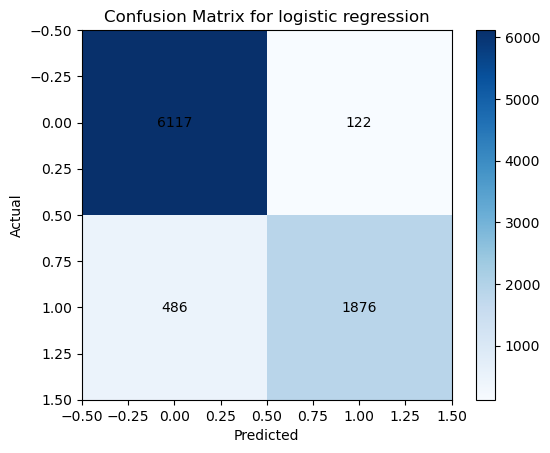

In [12]:
# Create a confusion matrix
cm = metrics.confusion_matrix(y_test, y_preds)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix for logistic regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Display the values of the confusion matrix
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i][j], ha='center', va='center')

# Display the plot
plt.show()

### 2. RANDOM FOREST

In [13]:
X = panda.DataFrame(modelling_features)
y = dataset['Toxicity'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow) 
acc2=accuracy_score(y_test,y_preds)
f1 = f1_score(y_test, y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print(f"F1-score (weighted): {f1:.4f}")
print("Random Forest, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      6239
           1       0.93      0.79      0.86      2362

    accuracy                           0.93      8601
   macro avg       0.93      0.88      0.90      8601
weighted avg       0.93      0.93      0.92      8601

F1-score (weighted): 0.9246
Random Forest, Accuracy Score: 0.9266364376235321


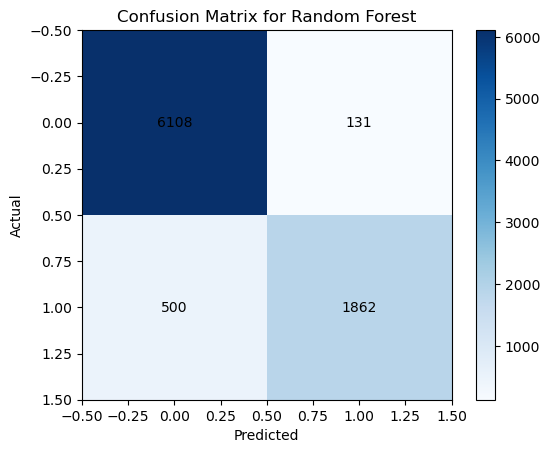

In [14]:
# Create a confusion matrix
cm = metrics.confusion_matrix(y_test, y_preds)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Display the values of the confusion matrix
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i][j], ha='center', va='center')

# Display the plot
plt.show()

### 3. SVM LINEAR 

In [15]:
X = panda.DataFrame(modelling_features)
y = dataset['Toxicity'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_preds)
f1 = f1_score(y_test, y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print(f"F1-score (weighted): {f1:.4f}")
print("SVM, Accuracy Score:" , acc3)


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6239
           1       0.92      0.83      0.88      2362

    accuracy                           0.94      8601
   macro avg       0.93      0.90      0.92      8601
weighted avg       0.93      0.94      0.93      8601

F1-score (weighted): 0.9343
SVM, Accuracy Score: 0.9353563539123357


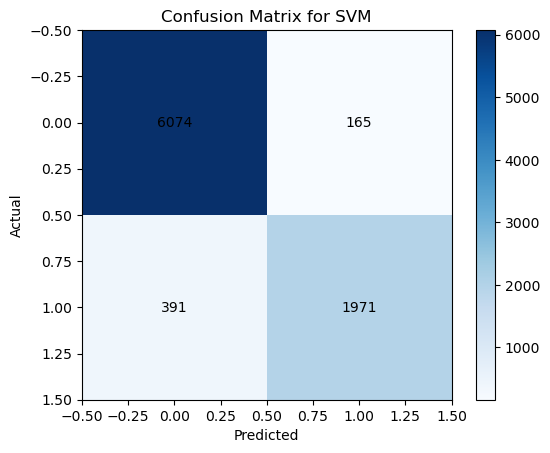

In [16]:
# Create a confusion matrix
cm = metrics.confusion_matrix(y_test, y_preds)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Display the values of the confusion matrix
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i][j], ha='center', va='center')

# Display the plot
plt.show()

### 4. DECISSION TREE

In [17]:
X = panda.DataFrame(modelling_features)
y = dataset['Toxicity'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =tree.DecisionTreeClassifier()
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc4=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
f1 = f1_score(y_test, y_preds, average='weighted')
print(report)
print(f"F1-score (weighted): {f1:.4f}")
print("Decission-Tree, Accuracy Score:" , acc4)


              precision    recall  f1-score   support

           0       0.92      0.95      0.93      6239
           1       0.85      0.79      0.82      2362

    accuracy                           0.90      8601
   macro avg       0.89      0.87      0.88      8601
weighted avg       0.90      0.90      0.90      8601

F1-score (weighted): 0.9024
Decission-Tree, Accuracy Score: 0.9034995930705731


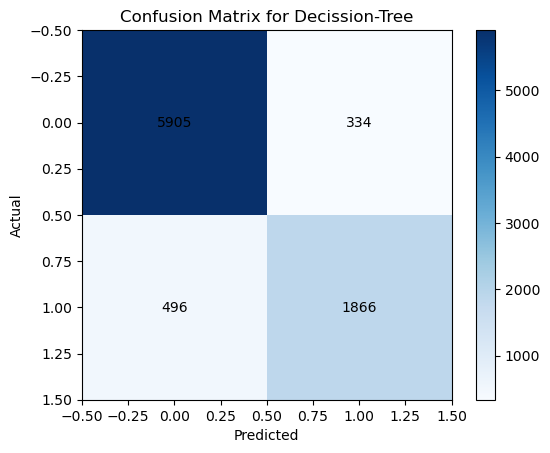

In [18]:
# Create a confusion matrix
cm = metrics.confusion_matrix(y_test, y_preds)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix for Decission-Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Display the values of the confusion matrix
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i][j], ha='center', va='center')

# Display the plot
plt.show()

### 5. ADA-BOOST 

In [19]:
X = panda.DataFrame(modelling_features)
y = dataset['Toxicity'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support = AdaBoostClassifier(n_estimators=100)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc5=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
f1 = f1_score(y_test, y_preds, average='weighted')
print(report)
print(f"F1-score (weighted): {f1:.4f}")
print("Ada-Boost, Accuracy Score:" , acc5)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      6239
           1       0.94      0.78      0.85      2362

    accuracy                           0.93      8601
   macro avg       0.93      0.88      0.90      8601
weighted avg       0.93      0.93      0.92      8601

F1-score (weighted): 0.9234
Ada-Boost, Accuracy Score: 0.9255900476688758


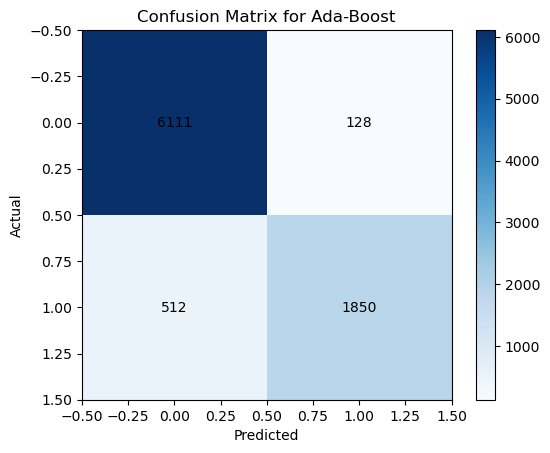

In [20]:
# Create a confusion matrix
cm = metrics.confusion_matrix(y_test, y_preds)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix for Ada-Boost')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Display the values of the confusion matrix
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i][j], ha='center', va='center')

# Display the plot
plt.show()

### 6. ADA-BOOST WITH DECISSION TREE

In [21]:
X = panda.DataFrame(modelling_features)
y = dataset['Toxicity'].astype(int)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create a decision tree classifier as the base estimator
base_estimator =tree.DecisionTreeClassifier()
# Create an Adaboost classifier
adaboost_clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)
# Train the Adaboost classifier
adaboost_clf.fit(X_train, y_train)
# Predict on the test set
y_preds = adaboost_clf.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)
f1 = f1_score(y_test, y_preds, average='weighted')
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_preds)
print(f"F1-score (weighted): {f1:.4f}")
print("AdaBoost with Decision tree Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      6239
           1       0.85      0.80      0.82      2362

    accuracy                           0.91      8601
   macro avg       0.89      0.87      0.88      8601
weighted avg       0.90      0.91      0.90      8601

F1-score (weighted): 0.9042
AdaBoost with Decision tree Accuracy: 0.9051273107778165


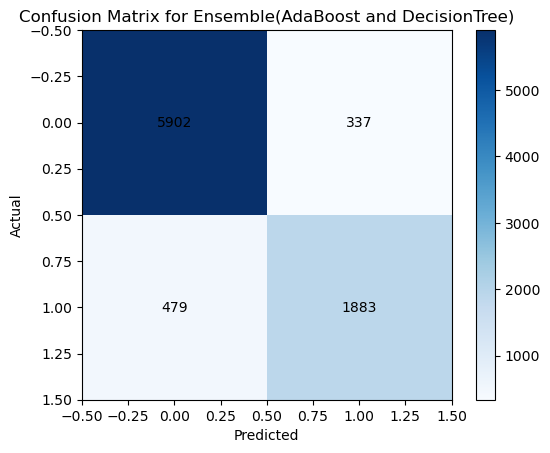

In [22]:
# Create a confusion matrix
cm = metrics.confusion_matrix(y_test, y_preds)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix for Ensemble(AdaBoost and DecisionTree)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Display the values of the confusion matrix
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i][j], ha='center', va='center')

# Display the plot
plt.show()

### 7. MLP

In [23]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
# Define and train the MLP model
mlp = MLPClassifier(solver='adam', alpha=0.001, hidden_layer_sizes=(128, 64), random_state=42)
mlp.fit(X_train_bow,y_train)
# Evaluate model performance
y_preds  = mlp.predict(X_test_bow)
acc6=accuracy_score(y_test,y_preds)
f1 = f1_score(y_test, y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print(f"Accuracy: {acc6:.4f}")
print(f"F1-score (weighted): {f1:.4f}")


              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6239
           1       0.86      0.86      0.86      2362

    accuracy                           0.92      8601
   macro avg       0.90      0.90      0.90      8601
weighted avg       0.92      0.92      0.92      8601

Accuracy: 0.9227
F1-score (weighted): 0.9227


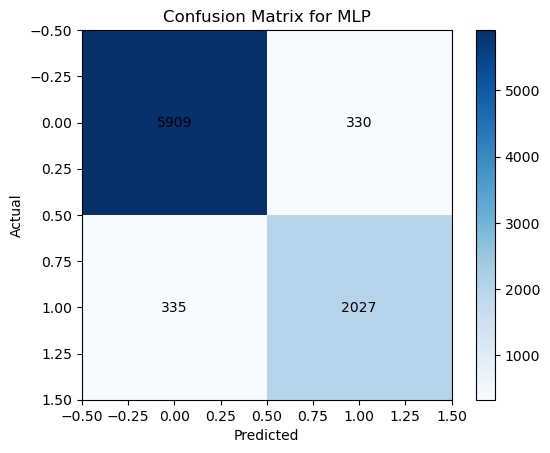

In [24]:
cm = metrics.confusion_matrix(y_test, y_preds)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix for MLP')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Display the values of the confusion matrix
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i][j], ha='center', va='center')

# Display the plot
plt.show()

## Graphs

### Accuracies

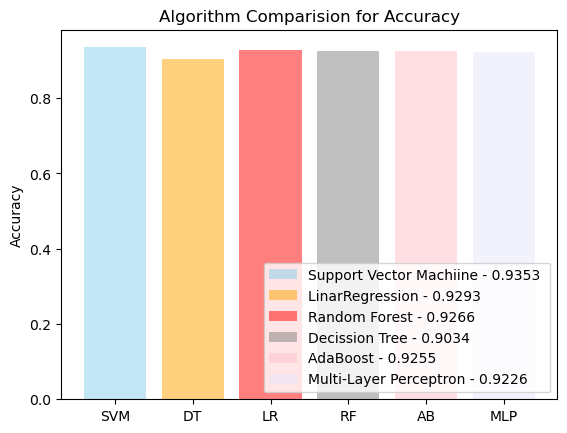

In [76]:
objects = ('SVM','DT','LR', 'RF', 'AB','MLP')
y_pos = np.arange(len(objects))
performance = [acc3,acc4,acc1,acc2,acc5,acc6]
colors=['skyblue','orange','red','grey','pink','lavender']
labels=['Support Vector Machiine - 0.9353 ', 'LinarRegression - 0.9293', 'Random Forest - 0.9266','Decission Tree - 0.9034','AdaBoost - 0.9255','Multi-Layer Perceptron - 0.9226']
bars=plt.bar(y_pos, performance, alpha=0.5, color=colors ,label=labels)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for Accuracy')
plt.legend(loc='lower right', )   
plt.show()


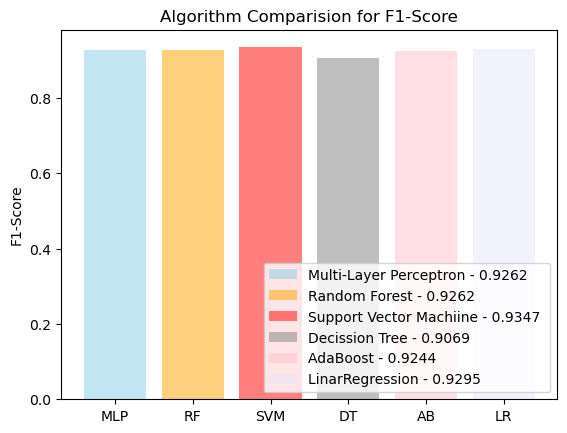

In [3]:
objects = ('MLP', 'RF', 'SVM','DT','AB','LR')
y_pos = np.arange(len(objects))
performance = [0.9262,0.9262,0.9347,0.9069,0.9244,0.9295]
colors=['skyblue','orange','red','grey','pink','lavender']
labels=['Multi-Layer Perceptron - 0.9262', 'Random Forest - 0.9262', 'Support Vector Machiine - 0.9347 ','Decission Tree - 0.9069' ,'AdaBoost - 0.9244','LinarRegression - 0.9295']
bars=plt.bar(y_pos, performance, alpha=0.5, color=colors ,label=labels)
plt.xticks(y_pos, objects)
plt.ylabel('F1-Score')
plt.title('Algorithm Comparision for F1-Score')
plt.legend(loc='lower right', )   
plt.show()

### F1-Scores

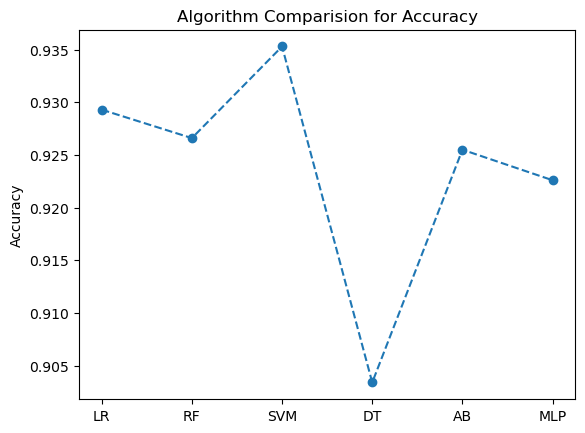

In [23]:
objects = ('LR', 'RF', 'SVM','DT','AB','MLP')
y_pos = np.arange(len(objects))
performance = [0.9293,0.9266,0.9353,0.9034,0.9255,0.9226]
labels=['LinarRegression', 'Random Forest', 'Support Vector Machiine','Decission Tree','AdaBoost','Multi-Layer Perceptron']
bars=plt.plot(y_pos, performance, marker='o', linestyle='--', label=labels)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for Accuracy')
plt.show()

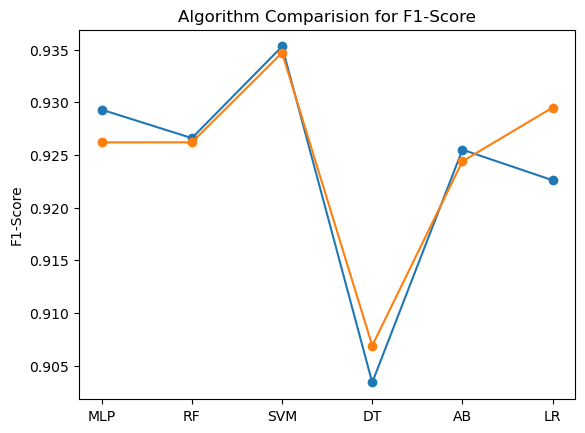

In [5]:
objects = ('MLP', 'RF', 'SVM','DT','AB','LR')
objects1 = ('MLP', 'RF', 'SVM','DT','AB','LR')
y_pos = np.arange(len(objects))
y_pos1 = np.arange(len(objects1))
performance1 = [0.9293,0.9266,0.9353,0.9034,0.9255,0.9226]
performance = [0.9262,0.9262,0.9347,0.9069,0.9244,0.9295]
labels=['Multi-Layer Perceptron', 'Random Forest', 'Support Vector Machiine','Decission Tree','AdaBoost','Logistic Regression']
bars1=plt.plot(y_pos1, performance1, marker='o', linestyle='-', label=labels)
bars=plt.plot(y_pos, performance, marker='o', linestyle='-', label=labels)
plt.xticks(y_pos, objects)
plt.ylabel('F1-Score')
plt.title('Algorithm Comparision for F1-Score')
plt.show()

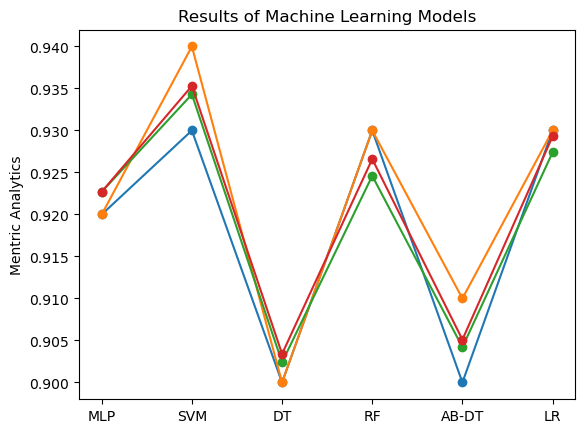

In [7]:
objects = ('MLP','SVM','DT','RF','AB-DT','LR')
y_pos = np.arange(len(objects))
Precision =[0.92, 0.93, 0.9, 0.93, 0.9, 0.93]
Recall=[0.92, 0.94, 0.9, 0.93, 0.91, 0.93]
F1_Score=[0.9227, 0.9343, 0.9024,  0.9246, 0.9042, 0.9274]
Accuracy=[0.9227, 0.9353, 0.9034, 0.9266, 0.9051, 0.9293]
bars1=plt.plot(y_pos,Precision , marker='o', linestyle='-')
bars2=plt.plot(y_pos,Recall , marker='o', linestyle='-')
bars3=plt.plot(y_pos,F1_Score , marker='o', linestyle='-')
bars4=plt.plot(y_pos,Accuracy , marker='o', linestyle='-')
plt.xticks(y_pos, objects)
plt.ylabel('Mentric Analytics')
plt.title('Results of Machine Learning Models')
plt.show()

In [ ]:
import numpy as np
